## Initialization (Code optimized for Colab CPU)

### Import all the libraries

In [37]:
!pip install streamlit -q
!pip install librosa soundfile -q

In [38]:
# ✅ Built-in modules
import os
import sys
import pickle
import shutil
import re
import platform
from collections import Counter, defaultdict
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed

# ✅ Third-party modules
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tqdm as tqdm_module
import librosa
import librosa.display
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, schedules
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import kagglehub
import joblib
import pkg_resources
import streamlit as st
from google.colab import files

# 🌐 System Info
print("📌 System Information:")
print(f"OS: {platform.system()} {platform.release()}")
print(f"Platform: {platform.platform()}")
print(f"Architecture: {platform.machine()}")
print(f"Processor: {platform.processor()}")
print(f"Python Version: {sys.version}")
print("-" * 50)

# 📦 Library Versions
print("📦 Library Versions:")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"tqdm: {tqdm_module.__version__}")
print(f"librosa: {librosa.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"imbalanced-learn (imblearn): {imblearn.__version__}")
print(f"tensorflow: {tf.__version__}")
print(f"joblib: {joblib.__version__}")
print(f"kagglehub: {getattr(kagglehub, '__version__', 'Unknown or not versioned')}")
print(f"streamlit: {st.__version__}")

# ✅ Installed packages
print("\n📋 Installed packages:")
installed_packages = sorted([(d.project_name, d.version) for d in pkg_resources.working_set])
for name, version in installed_packages:
    print(f"{name}=={version}")


📌 System Information:
OS: Linux 6.1.85+
Platform: Linux-6.1.85+-x86_64-with-glibc2.35
Architecture: x86_64
Processor: x86_64
Python Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
--------------------------------------------------
📦 Library Versions:
numpy: 2.0.2
pandas: 2.2.2
matplotlib: 3.10.0
seaborn: 0.13.2
tqdm: 4.67.1
librosa: 0.11.0
scikit-learn: 1.6.1
imbalanced-learn (imblearn): 0.13.0
tensorflow: 2.18.0
joblib: 1.4.2
kagglehub: 0.3.11
streamlit: 1.44.1

📋 Installed packages:
Bottleneck==1.4.2
Cython==3.0.12
Deprecated==1.2.18
Farama-Notifications==0.0.4
GDAL==3.6.4
GitPython==3.1.44
Mako==1.1.3
Markdown==3.7
MarkupSafe==3.0.2
PyDrive==1.3.1
PyDrive2==1.21.3
PyGObject==3.42.0
PyJWT==2.10.1
PyOpenGL==3.1.9
PySocks==1.7.1
PyYAML==6.0.2
Pyomo==6.8.2
SecretStorage==3.3.1
Send2Trash==1.8.3
absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotat

### System Information and Imported packages' Information

### Downloading all 4 datasets

In [19]:
# Download the Ravdess dataset
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)

# Download the CremaD dataset
path = kagglehub.dataset_download("ejlok1/cremad")
print("Path to dataset files:", path)

# Download the TESS dataset
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
print("Path to dataset files:", path)

# Download the Savee dataset
path = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")
print("Path to dataset files:", path)


# Move the datasets folder to contents
path = "/root/.cache/kagglehub/datasets"
shutil.move(path, "/content/")

100%|██████████| 429M/429M [00:01<00:00, 245MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


100%|██████████| 451M/451M [00:01<00:00, 242MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/cremad/versions/1


100%|██████████| 428M/428M [00:05<00:00, 76.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1


100%|██████████| 107M/107M [00:00<00:00, 257MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1


'/content/datasets'

## Data visualization  (Code optimized for Colab CPU)

### Number of .wav Files per Dataset

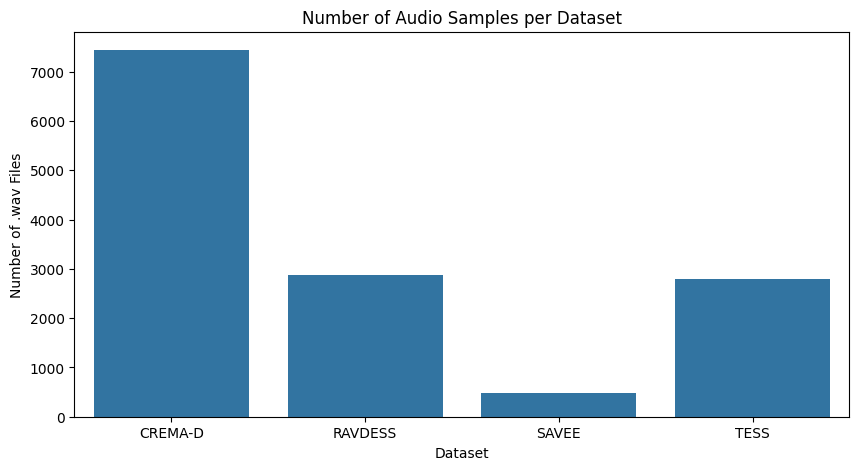

In [20]:
def count_wav_files(path):
    count = 0
    for root, _, files in os.walk(path):
        count += sum(1 for f in files if f.endswith(".wav"))
    return count

# Dataset paths
cremad_path = "/content/datasets/ejlok1/cremad/versions/1/AudioWAV"
ravdess_path = "/content/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1"
savee_path = "/content/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL"
tess_path = "/content/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS Toronto emotional speech set data"

# Count files
data_sizes = {
    "CREMA-D": count_wav_files(cremad_path),
    "RAVDESS": count_wav_files(ravdess_path),
    "SAVEE": count_wav_files(savee_path),
    "TESS": count_wav_files(tess_path),
}

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=list(data_sizes.keys()), y=list(data_sizes.values()))
plt.title("Number of Audio Samples per Dataset")
plt.ylabel("Number of .wav Files")
plt.xlabel("Dataset")
plt.show()


### Counting the number of files in the dataset

In [21]:
import os

dataset_paths = {
    "CREMA-D": "/content/datasets/ejlok1/cremad/versions/1/AudioWAV",
    "RAVDESS": "/content/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1",
    "SAVEE": "/content/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL",
    "TESS": "/content/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS Toronto emotional speech set data"
}

data_sizes = {
    name: sum(len(files) for _, _, files in os.walk(path))
    for name, path in dataset_paths.items()
}

print("📊 Dataset file counts:")
for name, count in data_sizes.items():
    print(f"📁 {name}: {count} .wav files")

print("\n\n Total .wav files: ", sum(data_sizes.values()))


📊 Dataset file counts:
📁 CREMA-D: 7442 .wav files
📁 RAVDESS: 2880 .wav files
📁 SAVEE: 480 .wav files
📁 TESS: 2800 .wav files


 Total .wav files:  13602


### Spectogram

🎼 Generating spectrograms for selected samples...


📁 Dataset: CREMA-D
✅ Found 7442 .wav files.


🔊 CREMA-D:   0%|          | 0/2 [00:00<?, ?it/s]

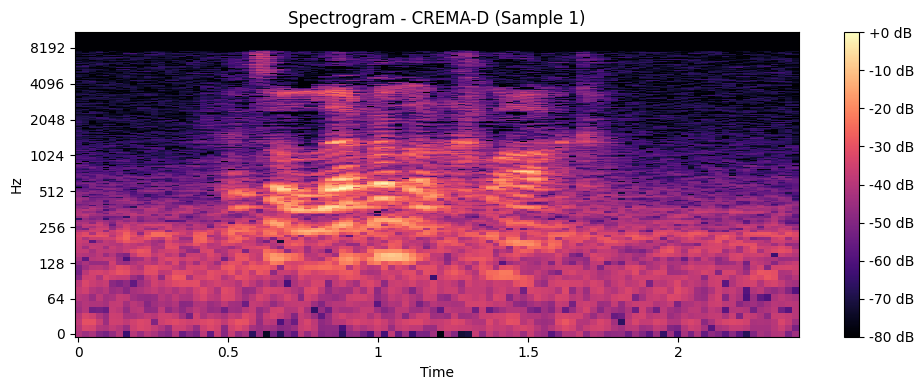

🔊 CREMA-D:  50%|█████     | 1/2 [00:12<00:12, 12.29s/it]

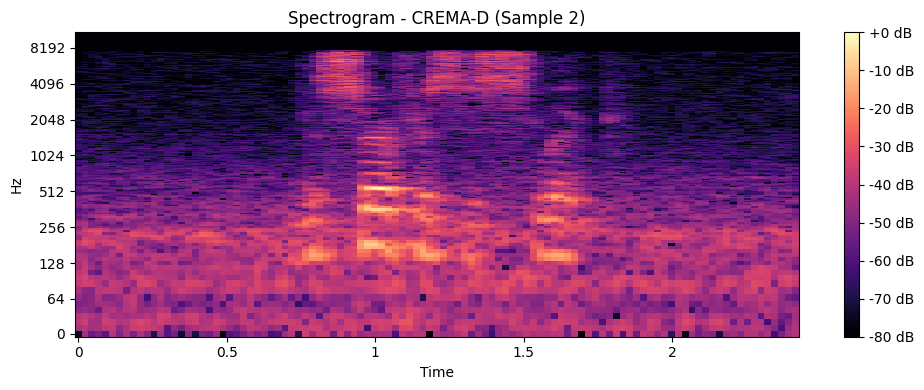

🔊 CREMA-D: 100%|██████████| 2/2 [00:12<00:00,  6.29s/it]



📁 Dataset: RAVDESS
✅ Found 2880 .wav files.


🔊 RAVDESS:   0%|          | 0/2 [00:00<?, ?it/s]

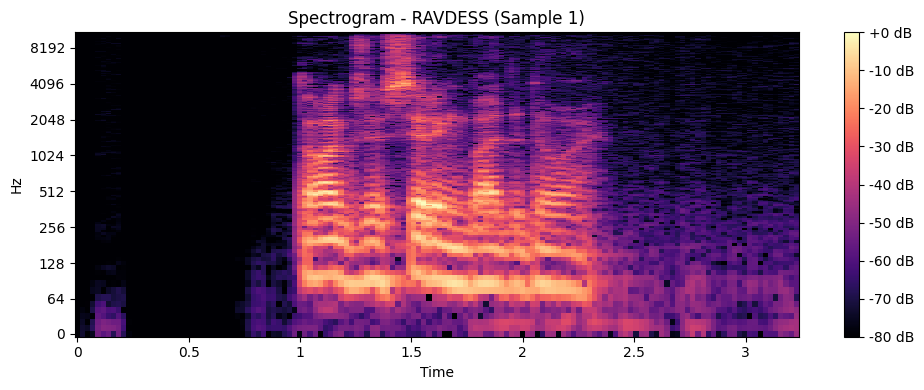

🔊 RAVDESS:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s]

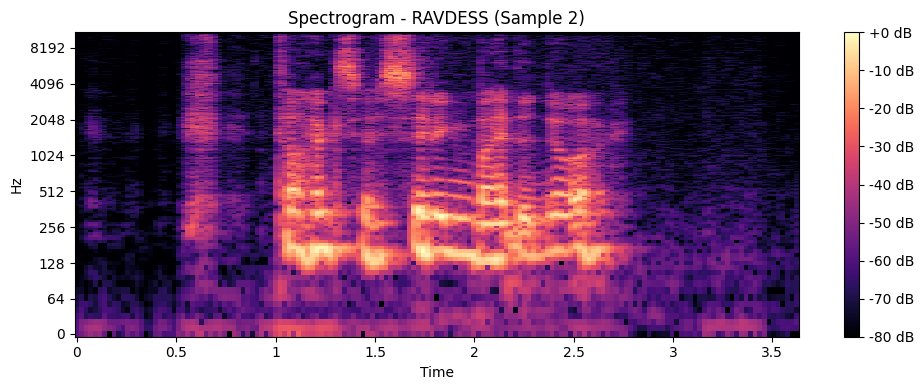

🔊 RAVDESS: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]



📁 Dataset: SAVEE
✅ Found 480 .wav files.


🔊 SAVEE:   0%|          | 0/2 [00:00<?, ?it/s]

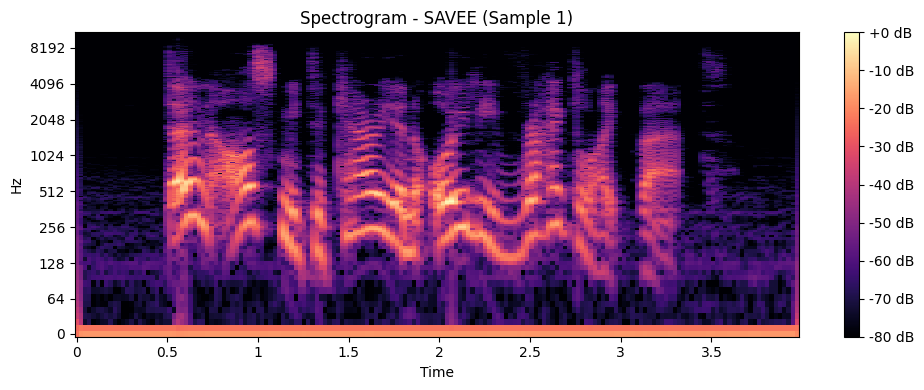

🔊 SAVEE:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s]

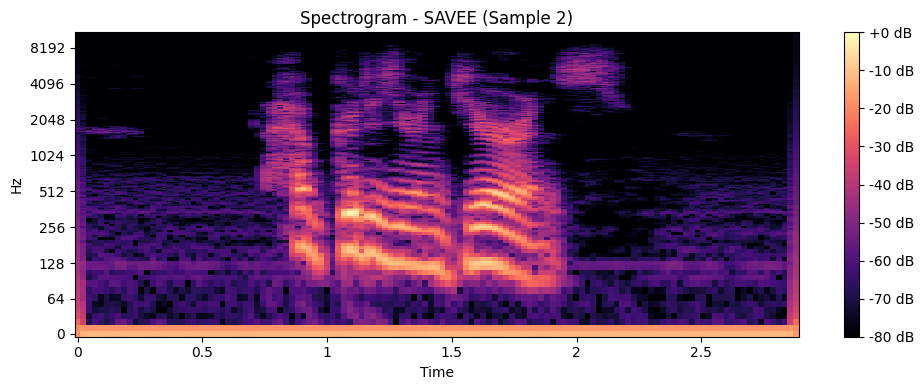

🔊 SAVEE: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]



📁 Dataset: TESS
✅ Found 2800 .wav files.


🔊 TESS:   0%|          | 0/2 [00:00<?, ?it/s]

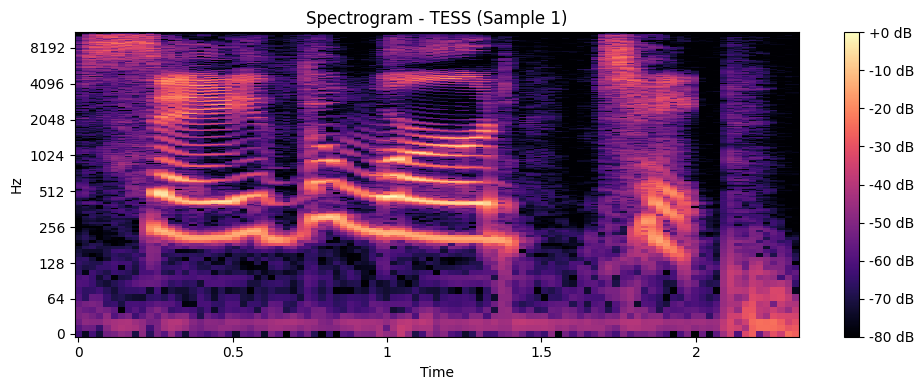

🔊 TESS:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s]

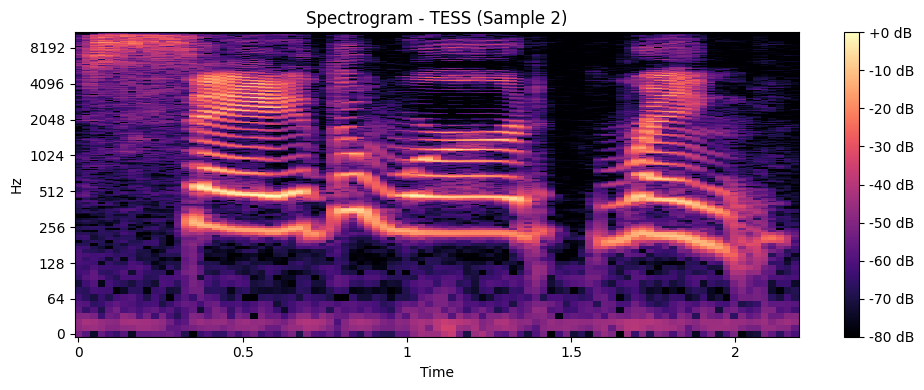

🔊 TESS: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


🎉 Spectrogram generation complete.


In [22]:
# Dataset paths
dataset_paths = {
    'CREMA-D': "/content/datasets/ejlok1/cremad/versions/1/AudioWAV",
    'RAVDESS': "/content/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1",
    'SAVEE': "/content/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL",
    'TESS': "/content/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS Toronto emotional speech set data"
}

# Visualize a spectrogram from a given file
def show_spectrogram(audio_path, dataset_name, sample_index):
    try:
        y, sr = librosa.load(audio_path)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram - {dataset_name} (Sample {sample_index})')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Error processing {audio_path}: {e}")

# Show N examples per dataset
samples_per_dataset = 2

print("🎼 Generating spectrograms for selected samples...\n")

for dataset_name, dataset_path in dataset_paths.items():
    print(f"\n📁 Dataset: {dataset_name}")
    wav_files = []

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))

    print(f"✅ Found {len(wav_files)} .wav files.")

    # Show spectrograms for first N files
    for i, file_path in enumerate(tqdm(wav_files[:samples_per_dataset], desc=f"🔊 {dataset_name}")):
        show_spectrogram(file_path, dataset_name, i + 1)

print("\n🎉 Spectrogram generation complete.")


### MFCC visualizations

🎧 Generating MFCC visualizations for selected samples...


📁 Dataset: CREMA-D
✅ Found 7442 .wav files.


🎼 CREMA-D:   0%|          | 0/2 [00:00<?, ?it/s]

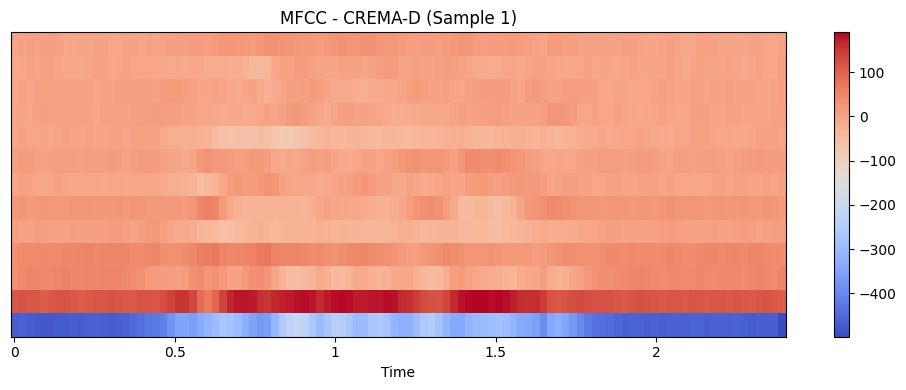

🎼 CREMA-D:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it]

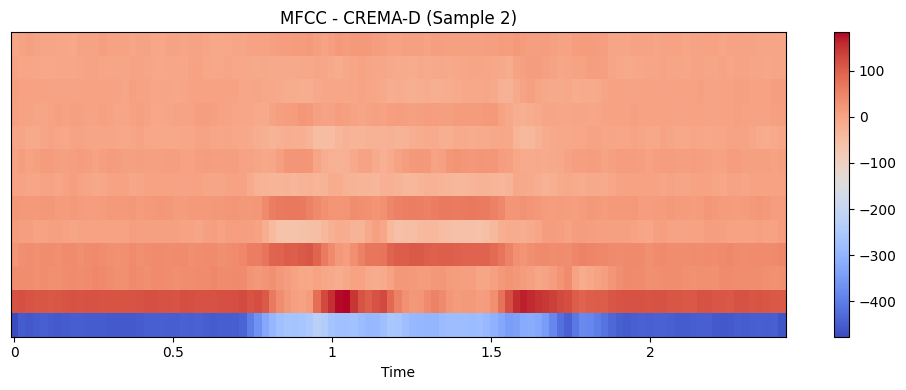

🎼 CREMA-D: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



📁 Dataset: RAVDESS
✅ Found 2880 .wav files.


🎼 RAVDESS:   0%|          | 0/2 [00:00<?, ?it/s]

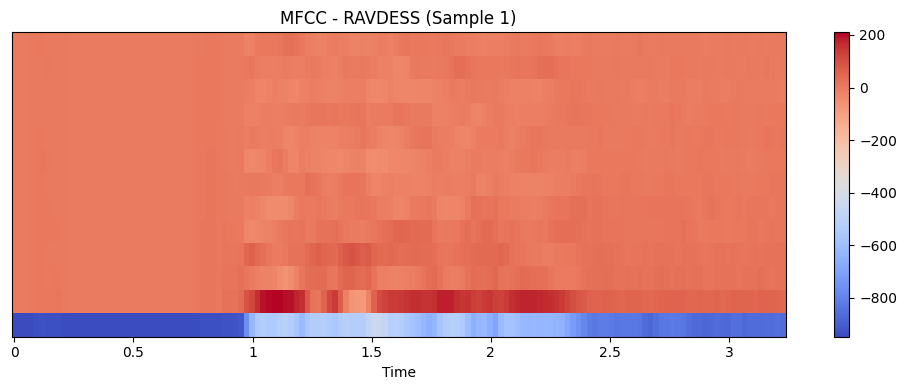

🎼 RAVDESS:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s]

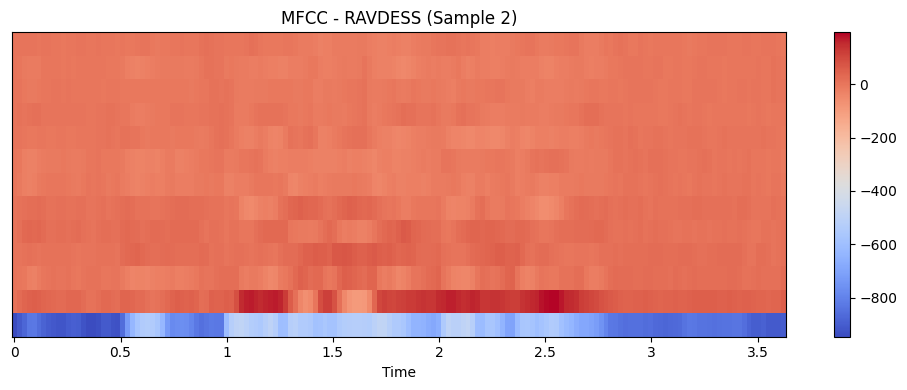

🎼 RAVDESS: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]



📁 Dataset: SAVEE
✅ Found 480 .wav files.


🎼 SAVEE:   0%|          | 0/2 [00:00<?, ?it/s]

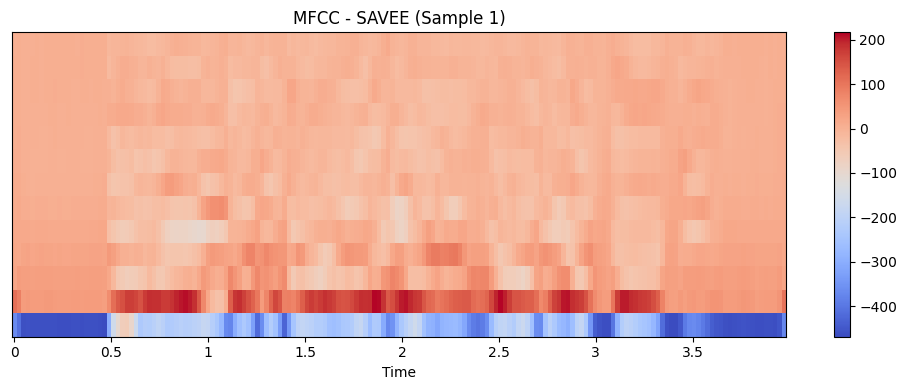

🎼 SAVEE:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s]

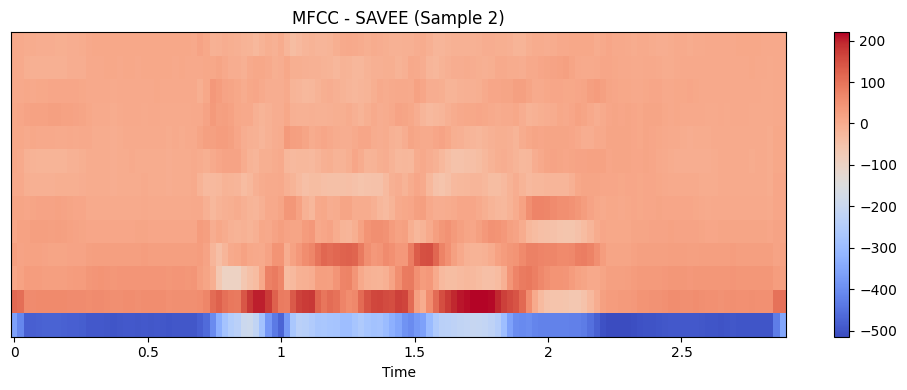

🎼 SAVEE: 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]



📁 Dataset: TESS
✅ Found 2800 .wav files.


🎼 TESS:   0%|          | 0/2 [00:00<?, ?it/s]

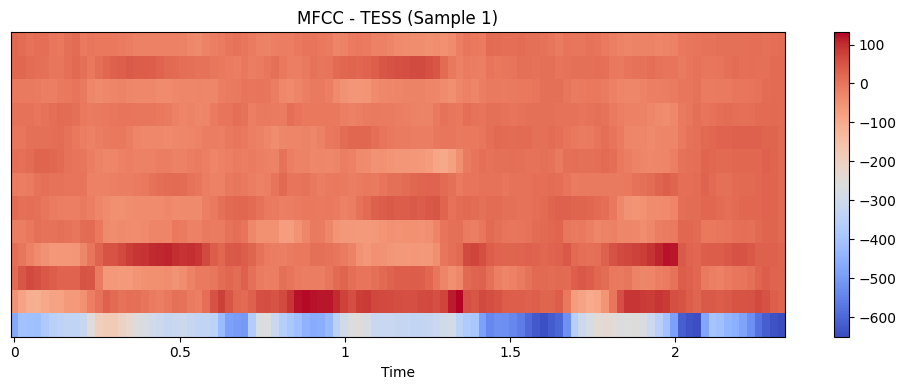

🎼 TESS:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s]

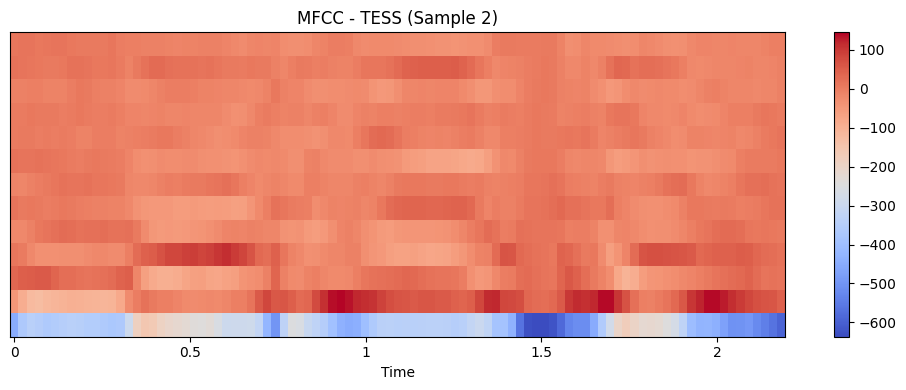

🎼 TESS: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


✅ All MFCCs plotted successfully.


''

In [23]:
# Dataset paths
dataset_paths = {
    'CREMA-D': "/content/datasets/ejlok1/cremad/versions/1/AudioWAV",
    'RAVDESS': "/content/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1",
    'SAVEE': "/content/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL",
    'TESS': "/content/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS Toronto emotional speech set data"
}

# Function to display MFCC heatmap
def plot_mfcc(audio_path, dataset_name, sample_index):
    try:
        y, sr = librosa.load(audio_path)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfccs, x_axis='time', sr=sr)
        plt.colorbar()
        plt.title(f'MFCC - {dataset_name} (Sample {sample_index})')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Error processing {audio_path}: {e}")

# Number of MFCC plots per dataset
samples_per_dataset = 2

print("🎧 Generating MFCC visualizations for selected samples...\n")

for dataset_name, dataset_path in dataset_paths.items():
    print(f"\n📁 Dataset: {dataset_name}")
    wav_files = []

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))

    print(f"✅ Found {len(wav_files)} .wav files.")

    # Visualize MFCCs for first N files
    for i, file_path in enumerate(tqdm(wav_files[:samples_per_dataset], desc=f"🎼 {dataset_name}")):
        plot_mfcc(file_path, dataset_name, i + 1)

print("\n✅ All MFCCs plotted successfully.")
''

### Number of Audio Samples per Emotion

<ipython-input-24-f5e4ba34498a>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(emotion_counts_sorted.keys()), y=list(emotion_counts_sorted.values()), palette='pastel')
<ipython-input-24-f5e4ba34498a>:105: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


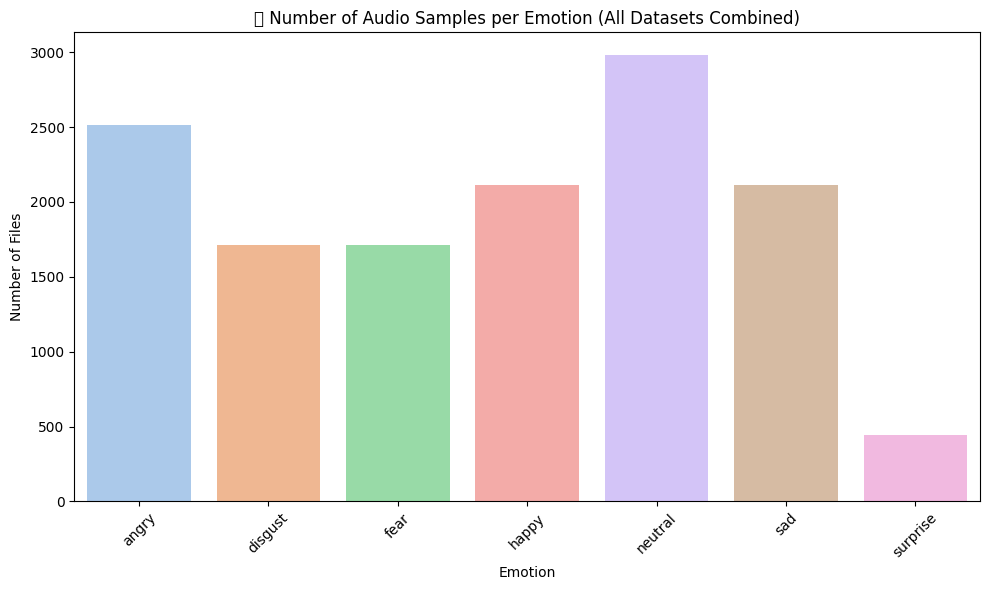


📊 Total number of audio samples detected: 13602
🧪 Emotion-mapped samples: 13602
❌ Unmapped files: 0


In [24]:
# Unified emotion mapping
mapping = {
    'neutral': ['01', '02', 'calm', 'neutral', 'neu', 'n'],
    'happy': ['03', 'happy', 'hap', 'h'],
    'sad': ['04', 'sad', 'sadness', 'sa'],
    'angry': ['05', 'angry', 'anger', 'a', 'ang'],
    'fear': ['06', 'fear', 'fearful', 'f', 'fea'],
    'disgust': ['07', 'disgust', 'disgusted', 'd', 'dis'],
    'surprise': ['08', 'surprised', 'surprise', 'ps', 'pleasant', 'su', 'surp']
}

# Dataset-specific paths
paths = {
    'CREMA-D': "/content/datasets/ejlok1/cremad/versions/1/AudioWAV",
    'RAVDESS': "/content/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1",
    'SAVEE': "/content/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL",
    'TESS': "/content/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS Toronto emotional speech set data"
}

emotion_counts = defaultdict(int)
total_files = 0
unmapped_files = []

def map_emotion(code):
    code = code.lower()
    for emotion, tags in mapping.items():
        if code in tags:
            return emotion
    return None

# --- 1. CREMA-D ---
crema_path = paths['CREMA-D']
for file in os.listdir(crema_path):
    if file.endswith('.wav'):
        total_files += 1
        parts = file.split('_')
        if len(parts) >= 3:
            emotion = map_emotion(parts[2])
            if emotion:
                emotion_counts[emotion] += 1
            else:
                unmapped_files.append(file)

# --- 2. RAVDESS ---
ravdess_path = paths['RAVDESS']
for root, _, files in os.walk(ravdess_path):
    for file in files:
        if file.endswith('.wav') and '-' in file:
            total_files += 1
            parts = file.split('-')
            if len(parts) >= 3:
                emotion = map_emotion(parts[2])
                if emotion:
                    emotion_counts[emotion] += 1
                else:
                    unmapped_files.append(file)

# --- 3. SAVEE ---
savee_path = paths['SAVEE']
for file in os.listdir(savee_path):
    if file.endswith('.wav'):
        total_files += 1
        filename = file.replace('.wav', '')
        emotion_suffix = filename.split('_')[-1].lower()

        # Extract the prefix part: e.g., 'h' from 'h02', or 'sa' from 'sa12'
        emotion_prefix = ''.join(filter(str.isalpha, emotion_suffix))

        emotion = map_emotion(emotion_prefix)
        if emotion:
            emotion_counts[emotion] += 1
        else:
            unmapped_files.append(file)

# --- 4. TESS ---
tess_path = paths['TESS']
for root, _, files in os.walk(tess_path):
    for file in files:
        if file.endswith('.wav'):
            total_files += 1
            folder_name = os.path.basename(root).lower()
            matched = False
            for emotion, tags in mapping.items():
                if any(tag in folder_name for tag in tags):
                    emotion_counts[emotion] += 1
                    matched = True
                    break
            if not matched:
                unmapped_files.append(file)

# --- Plotting ---
emotion_counts_sorted = dict(sorted(emotion_counts.items(), key=lambda x: x[0]))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(emotion_counts_sorted.keys()), y=list(emotion_counts_sorted.values()), palette='pastel')
plt.title("🧠 Number of Audio Samples per Emotion (All Datasets Combined)")
plt.ylabel("Number of Files")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ✅ Display totals
print(f"\n📊 Total number of audio samples detected: {total_files}")
print(f"🧪 Emotion-mapped samples: {sum(emotion_counts.values())}")
print(f"❌ Unmapped files: {len(unmapped_files)}")

if unmapped_files:
    print("🔍 Sample unmapped files:")
    for f in unmapped_files[:10]:
        print(f" - {f}")


### Plotting duration histogram

🔍 Scanning for .wav files...
✅ Found 16402 .wav files.
⚙️ Calculating durations (this may take a while)...


100%|██████████| 16402/16402 [00:01<00:00, 9562.02it/s] 


🎯 Done processing all files. 16402 durations successfully computed.
📊 Plotting duration histogram...


<ipython-input-25-b0477e1602fa>:48: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


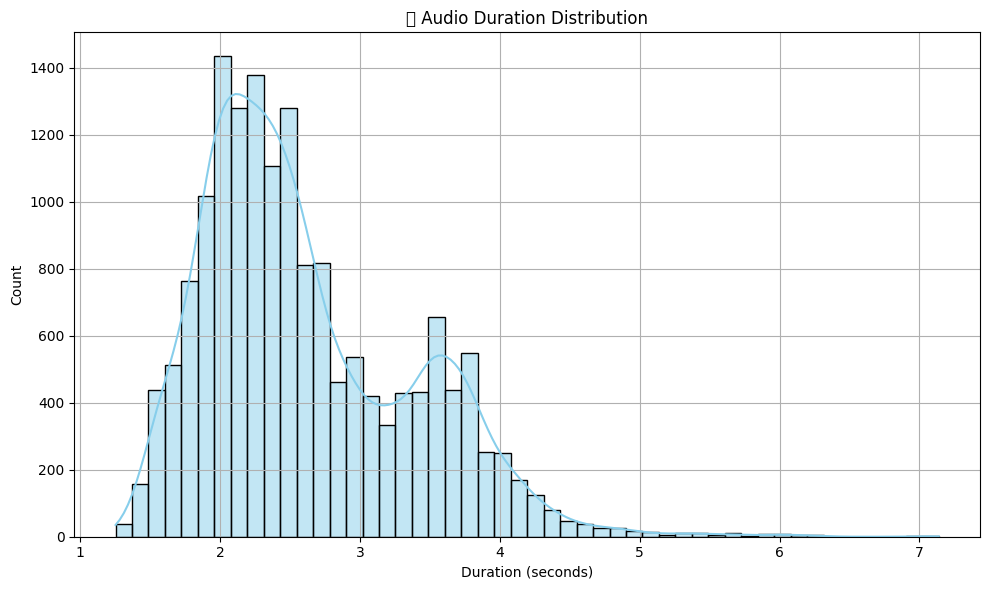

✅ Plot generated.


In [25]:
base_path = "/content/datasets"  # your root dataset folder

durations = []

# Worker function to process a single file
def process_file(filepath):
    try:
        return librosa.get_duration(path=filepath)  # ✅ No more warning
    except Exception:
        return None

# Step 1: Collect all .wav file paths
print("🔍 Scanning for .wav files...")
wav_files = []
for root, _, files in os.walk(base_path):
    for file in files:
        if file.endswith('.wav'):
            wav_files.append(os.path.join(root, file))

print(f"✅ Found {len(wav_files)} .wav files.")
print("⚙️ Calculating durations (this may take a while)...")

# Step 2: Process files in parallel with tqdm
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(process_file, path): path for path in wav_files}
    for future in tqdm(as_completed(futures), total=len(futures)):
        duration = future.result()
        if duration is not None:
            durations.append(duration)

print(f"🎯 Done processing all files. {len(durations)} durations successfully computed.")

# Step 3: Plot
print("📊 Plotting duration histogram...")
plt.figure(figsize=(10, 6))
sns.histplot(durations, bins=50, kde=True, color='skyblue')
plt.title("🎧 Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()
print("✅ Plot generated.")


### MFCC Feature Extraction and Plotting from Speech Datasets

🔍 Starting MFCC extraction & visualization...


📁 Processing dataset: CREMA-D
✅ Found 7442 .wav files in CREMA-D


🎧 Extracting MFCCs from CREMA-D:   0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-26-2a90de381d86>:45: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


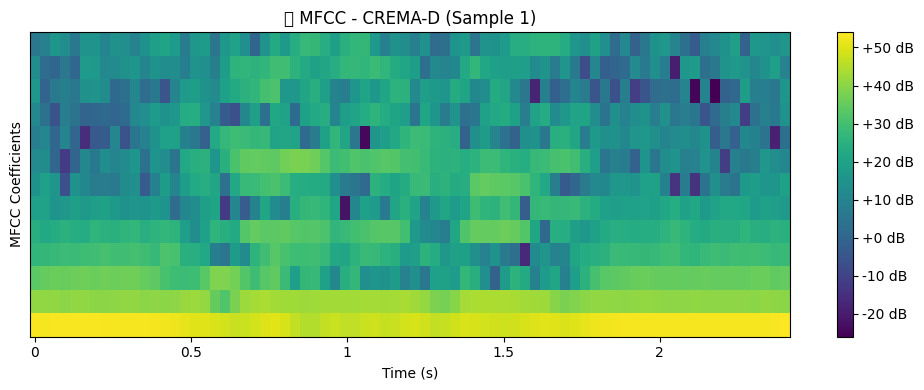

🎧 Extracting MFCCs from CREMA-D:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s]

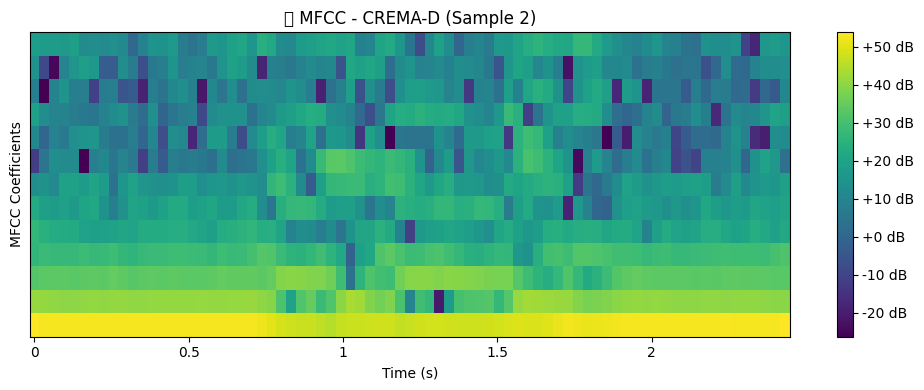

🎧 Extracting MFCCs from CREMA-D: 100%|██████████| 2/2 [00:00<00:00,  6.22it/s]



📁 Processing dataset: RAVDESS
✅ Found 2880 .wav files in RAVDESS


🎧 Extracting MFCCs from RAVDESS:   0%|          | 0/2 [00:00<?, ?it/s]

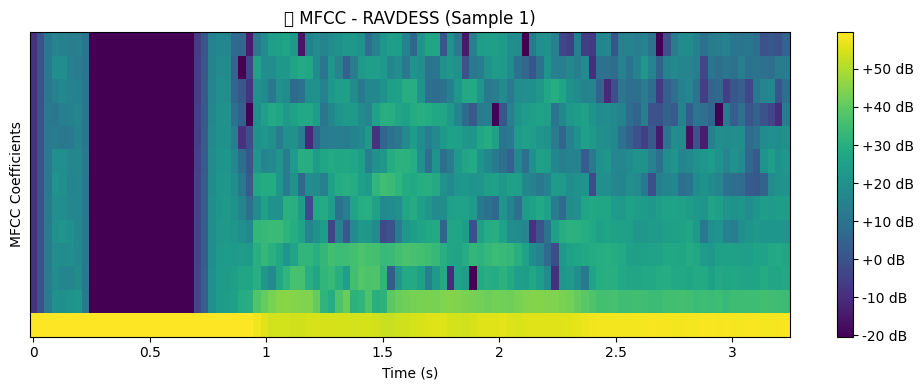

🎧 Extracting MFCCs from RAVDESS:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s]

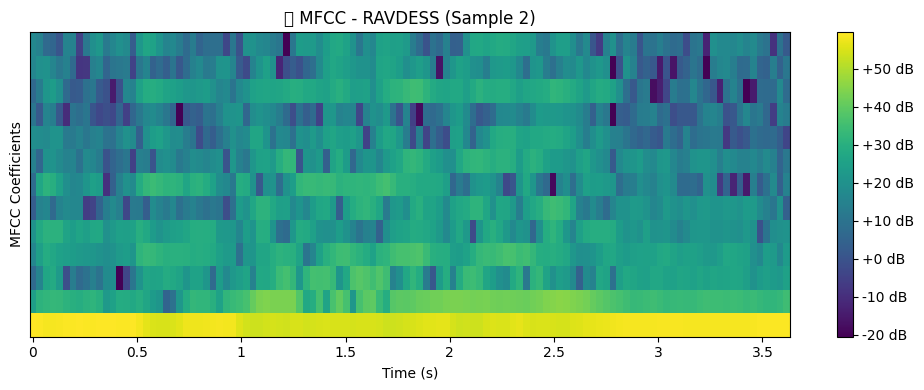

🎧 Extracting MFCCs from RAVDESS: 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]



📁 Processing dataset: SAVEE
✅ Found 480 .wav files in SAVEE


🎧 Extracting MFCCs from SAVEE:   0%|          | 0/2 [00:00<?, ?it/s]

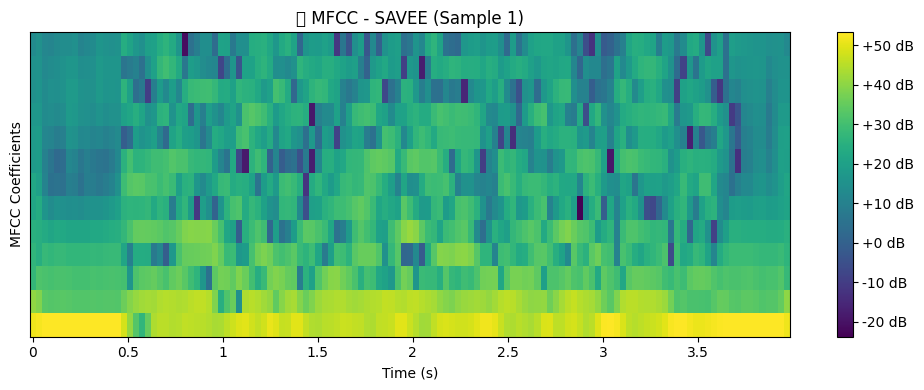

🎧 Extracting MFCCs from SAVEE:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s]

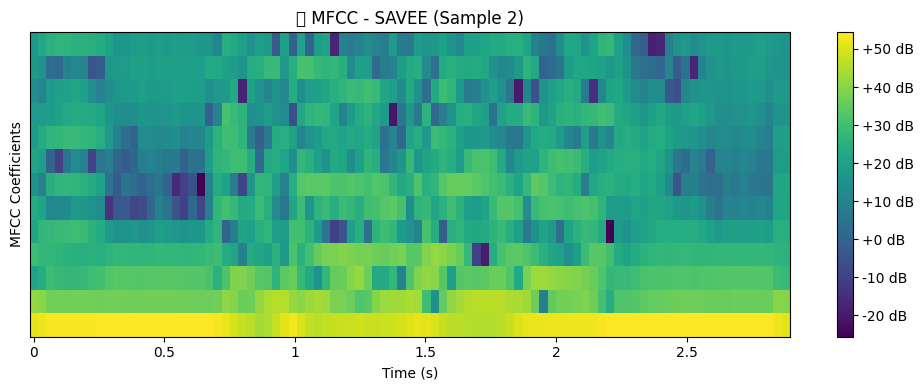

🎧 Extracting MFCCs from SAVEE: 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]



📁 Processing dataset: TESS
✅ Found 2800 .wav files in TESS


🎧 Extracting MFCCs from TESS:   0%|          | 0/2 [00:00<?, ?it/s]

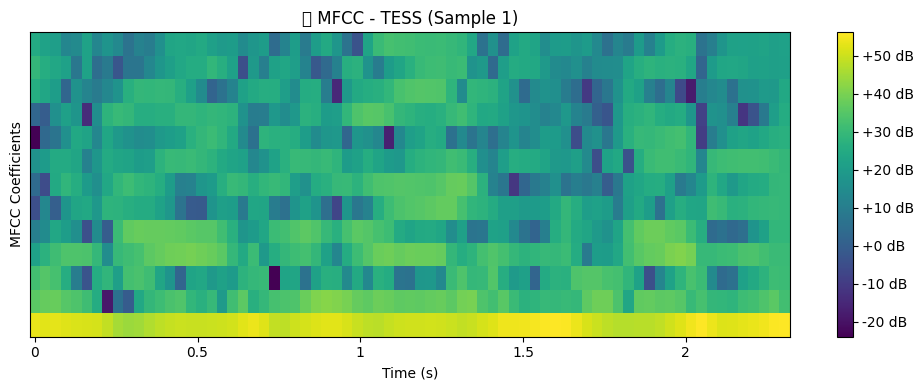

🎧 Extracting MFCCs from TESS:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s]

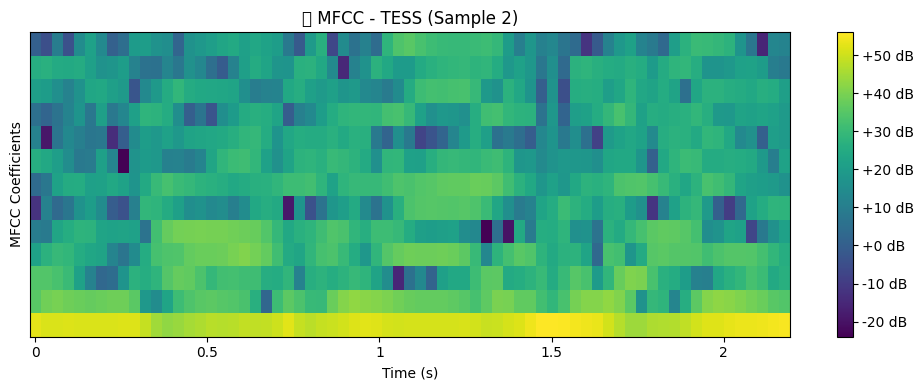

🎧 Extracting MFCCs from TESS: 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


🎉 All datasets processed!


In [26]:
# Dataset paths
dataset_paths = {
    'CREMA-D': "/content/datasets/ejlok1/cremad/versions/1/AudioWAV",
    'RAVDESS': "/content/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1",
    'SAVEE': "/content/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL",
    'TESS': "/content/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS Toronto emotional speech set data"
}

samples_per_dataset = 2
target_sr = 16000  # Consistent sampling rate
n_mfcc = 13
hop_length = 512  # Controls the time resolution of MFCC

print("🔍 Starting MFCC extraction & visualization...\n")

for dataset_name, dataset_path in dataset_paths.items():
    print(f"\n📁 Processing dataset: {dataset_name}")
    wav_files = []

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))

    print(f"✅ Found {len(wav_files)} .wav files in {dataset_name}")

    for i, file_path in enumerate(tqdm(wav_files[:samples_per_dataset], desc=f"🎧 Extracting MFCCs from {dataset_name}")):
        try:
            y, sr = librosa.load(file_path, sr=target_sr)  # Force same SR
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
            mfcc_db = librosa.power_to_db(mfcc**2)

            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mfcc_db, x_axis='time', sr=sr, hop_length=hop_length, cmap='viridis')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"🎵 MFCC - {dataset_name} (Sample {i+1})")
            plt.ylabel("MFCC Coefficients")
            plt.xlabel("Time (s)")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"⚠️ Skipped: {file_path}\nError: {e}")

print("\n🎉 All datasets processed!")


### PCA Plot of MFCCs

🚀 Extracting MFCCs from 13602 files using parallel processing...



100%|██████████| 13602/13602 [03:13<00:00, 70.13it/s] 



✅ Processed: 680100 MFCC frames
❌ Unmapped files: 0


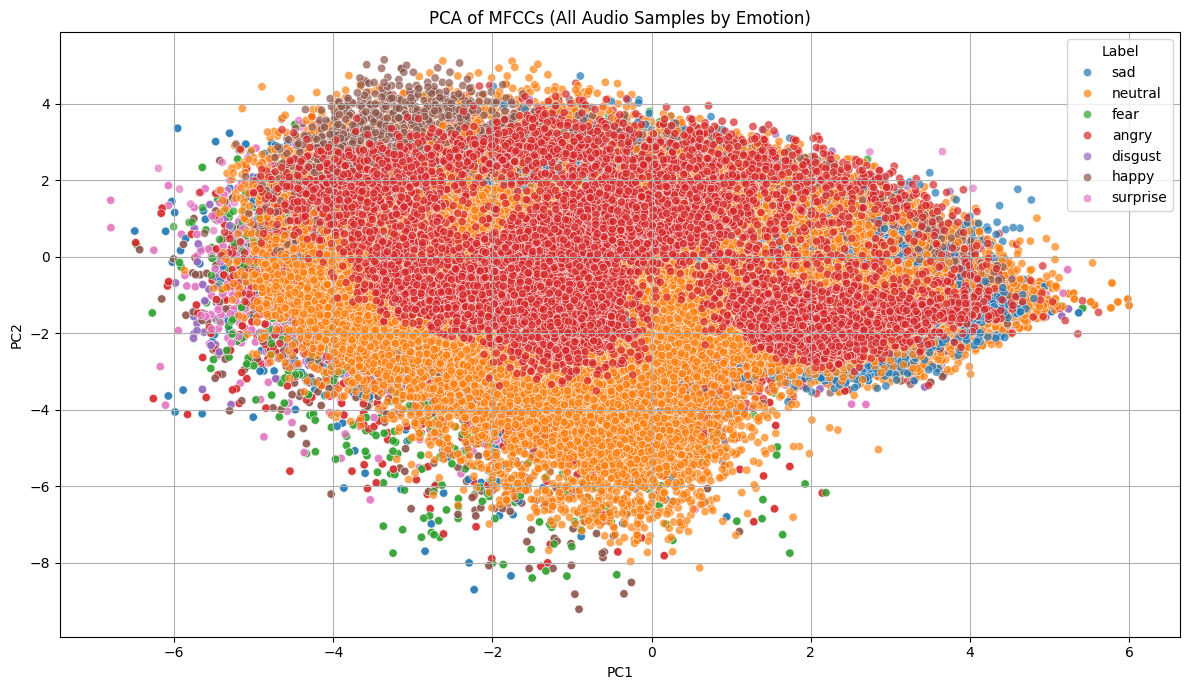

In [27]:
# Emotion mapping
emotion_mapping = {
    'neutral': ['01', '02', 'calm', 'neutral', 'neu', 'n'],
    'happy': ['03', 'happy', 'hap', 'h'],
    'sad': ['04', 'sad', 'sadness', 'sa'],
    'angry': ['05', 'angry', 'anger', 'a', 'ang'],
    'fear': ['06', 'fear', 'fearful', 'f', 'fea'],
    'disgust': ['07', 'disgust', 'disgusted', 'd', 'dis'],
    'surprise': ['08', 'surprised', 'surprise', 'ps', 'pleasant', 'su', 'surp']
}

# Dataset paths
dataset_paths = {
    'CREMA-D': "/content/datasets/ejlok1/cremad/versions/1/AudioWAV",
    'RAVDESS': "/content/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1",
    'SAVEE': "/content/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL",
    'TESS': "/content/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS Toronto emotional speech set data"
}

def decode(code):
    code = code.lower()
    for emotion, patterns in emotion_mapping.items():
        if code in patterns:
            return emotion
    return None

def map_emotion(file_path, dataset):
    file = os.path.basename(file_path).lower()
    if dataset == 'CREMA-D':
        parts = file.split('_')
        if len(parts) >= 3:
            return decode(parts[2])
    elif dataset == 'RAVDESS':
        parts = file.split('-')
        if len(parts) >= 3:
            return decode(parts[2])
    elif dataset == 'SAVEE':
        filename = file.replace('.wav', '')
        suffix = filename.split('_')[-1]
        prefix = ''.join(filter(str.isalpha, suffix))
        return decode(prefix)
    elif dataset == 'TESS':
        folder = os.path.basename(os.path.dirname(file_path)).lower()
        for emotion, tags in emotion_mapping.items():
            if any(tag in folder for tag in tags):
                return emotion
    return None

def extract_mfcc(file_path, dataset, target_length=50):
    label = map_emotion(file_path, dataset)
    if label:
        try:
            y, sr = librosa.load(file_path, sr=16000)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T
            if mfcc.shape[0] < target_length:
                mfcc = np.pad(mfcc, ((0, target_length - mfcc.shape[0]), (0, 0)), mode='constant')
            else:
                mfcc = mfcc[:target_length]
            return (mfcc, label)  # 🚨 fixed: use only emotion label
        except:
            return None
    else:
        return "unmapped", file_path

# --- Main Parallel Processing Block ---
if __name__ == "__main__":
    all_files = []

    for dataset, path in dataset_paths.items():
        for root, _, files in os.walk(path):
            for file in files:
                if file.endswith('.wav'):
                    all_files.append((os.path.join(root, file), dataset))

    print(f"🚀 Extracting MFCCs from {len(all_files)} files using parallel processing...\n")

    all_features = []
    all_labels = []
    unmapped_files = []

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(extract_mfcc, file_path, dataset) for file_path, dataset in all_files]
        for future in tqdm(as_completed(futures), total=len(futures)):
            result = future.result()
            if result is None:
                continue
            elif isinstance(result, tuple) and isinstance(result[0], np.ndarray):
                mfcc, label = result
                all_features.extend(mfcc)
                all_labels.extend([label] * mfcc.shape[0])  # ✔ label is now just emotion
            elif result[0] == "unmapped":
                unmapped_files.append(result[1])

    print(f"\n✅ Processed: {len(all_features)} MFCC frames")
    print(f"❌ Unmapped files: {len(unmapped_files)}")

    # --- PCA Visualization ---
    X = StandardScaler().fit_transform(np.array(all_features))
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    df = pd.DataFrame(components, columns=['PC1', 'PC2'])
    df['Label'] = all_labels

    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', palette='tab10', alpha=0.7)
    plt.title("PCA of MFCCs (All Audio Samples by Emotion)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Full Feature Extraction & t-SNE

🎧 Total usable files with emotion labels: 13602
⚡ Extracting MFCC features in parallel...


100%|██████████| 13602/13602 [01:05<00:00, 206.80it/s]


🔄 Scaling & Running t-SNE...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
<ipython-input-28-d4a38cb55c39>:118: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


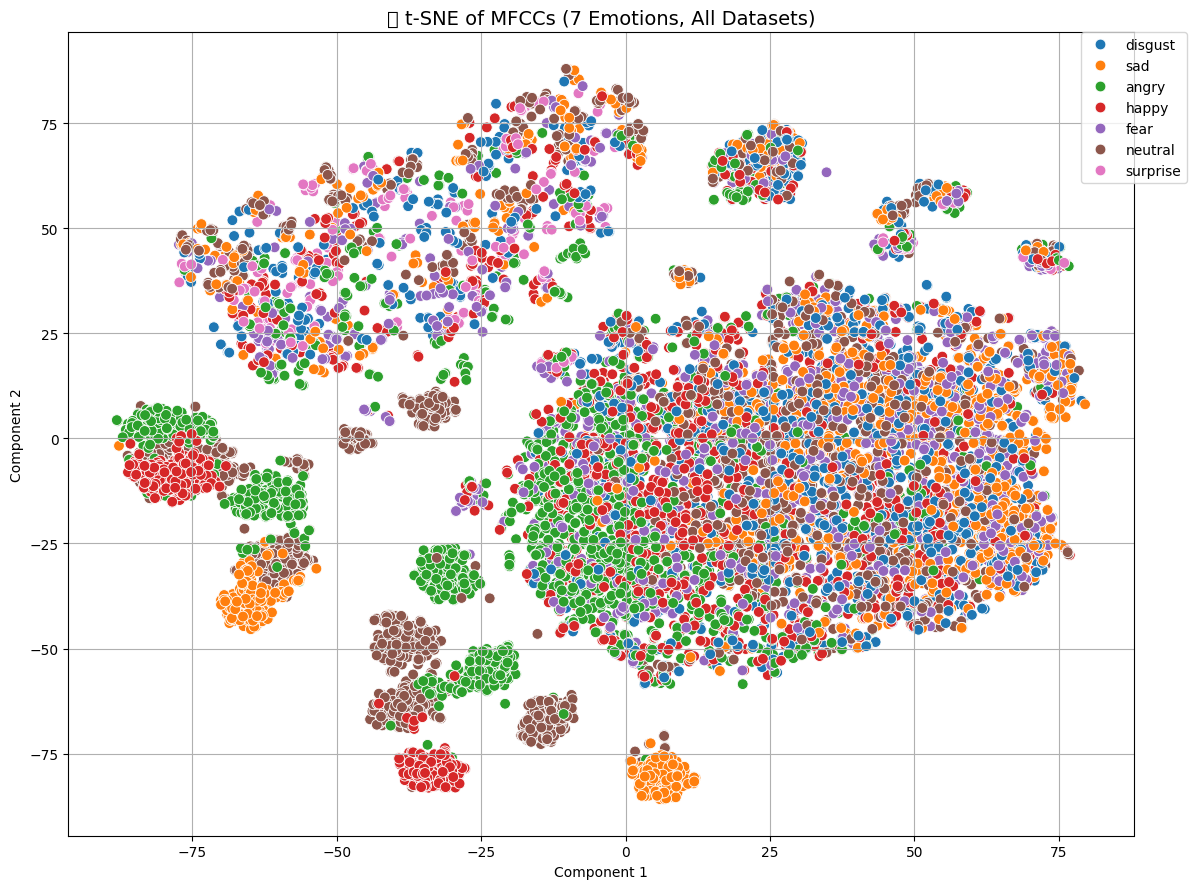

In [28]:
np.complex = complex  # Compatibility fix for librosa

# Emotion mapping
emotion_mapping = {
    'neutral': ['01', '02', 'calm', 'neutral', 'neu', 'n'],
    'happy': ['03', 'happy', 'hap', 'h'],
    'sad': ['04', 'sad', 'sadness', 'sa'],
    'angry': ['05', 'angry', 'anger', 'a', 'ang'],
    'fear': ['06', 'fear', 'fearful', 'f', 'fea'],
    'disgust': ['07', 'disgust', 'disgusted', 'd', 'dis'],
    'surprise': ['08', 'surprised', 'surprise', 'ps', 'pleasant', 'su', 'surp']
}

# Dataset paths
dataset_paths = {
    'CREMA-D': "/content/datasets/ejlok1/cremad/versions/1/AudioWAV",
    'RAVDESS': "/content/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1",
    'SAVEE': "/content/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL",
    'TESS': "/content/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS Toronto emotional speech set data"
}

# Emotion inference from filename
def map_emotion(file, root, dataset):
    file_lower = file.lower()
    root_lower = root.lower()

    if dataset == 'CREMA-D':
        parts = file.split('_')
        if len(parts) >= 3:
            code = parts[2].lower()
            for emo, tags in emotion_mapping.items():
                if code in tags:
                    return emo

    elif dataset == 'RAVDESS':
        parts = file.split('-')
        if len(parts) >= 3:
            code = parts[2]
            for emo, tags in emotion_mapping.items():
                if code in tags:
                    return emo

    elif dataset == 'SAVEE':
        filename = os.path.splitext(file)[0]
        code = ''.join(filter(str.isalpha, filename.split('_')[-1].lower()))
        for emo, tags in emotion_mapping.items():
            if code in tags:
                return emo

    elif dataset == 'TESS':
        folder_name = os.path.basename(root).lower()
        for emo, tags in emotion_mapping.items():
            if any(tag in folder_name for tag in tags):
                return emo

    # Fallback: tag-based detection
    for emo, tags in emotion_mapping.items():
        if any(tag in file_lower for tag in tags) or any(tag in root_lower for tag in tags):
            return emo

    return None

# Build list of (filepath, emotion)
file_emotion_list = []
for dataset, base in dataset_paths.items():
    for root, _, files in os.walk(base):
        for file in files:
            if file.endswith('.wav'):
                emotion = map_emotion(file, root, dataset)
                if emotion:
                    file_emotion_list.append((os.path.join(root, file), emotion))

print(f"🎧 Total usable files with emotion labels: {len(file_emotion_list)}")

# Feature extraction
def extract_mfcc(path, emotion):
    try:
        y, sr = librosa.load(path, sr=None, duration=3.5)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return np.mean(mfccs.T, axis=0), emotion
    except:
        return None

# Parallel MFCC processing
print("⚡ Extracting MFCC features in parallel...")
results = Parallel(n_jobs=-1, backend="loky")(
    delayed(extract_mfcc)(path, emo) for path, emo in tqdm(file_emotion_list)
)

# Clean & separate features and labels
valid_results = [r for r in results if r is not None]
features, labels = zip(*valid_results)

# Scale and t-SNE
print("🔄 Scaling & Running t-SNE...")
X_scaled = StandardScaler().fit_transform(features)
tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(12, 9))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=labels, palette='tab10', s=60)
plt.title("🎭 t-SNE of MFCCs (7 Emotions, All Datasets)", fontsize=14)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()


### Pie-chart of all the emotions in all the datasets

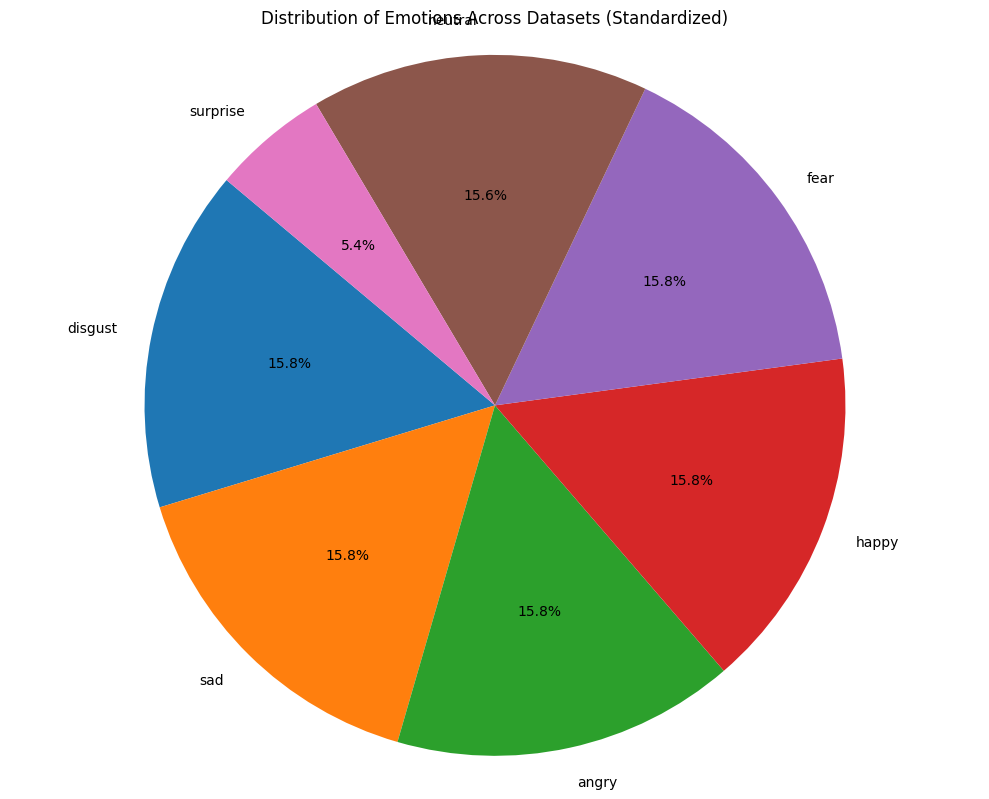


Standardized Emotion Labels:

disgust
sad
angry
happy
fear
neutral
surprise


In [29]:
# Dataset paths
dataset_paths = {
    'CREMA-D': "/content/datasets/ejlok1/cremad/versions/1/AudioWAV",
    'RAVDESS': "/content/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1",
    'SAVEE': "/content/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL",
    'TESS': "/content/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS Toronto emotional speech set data"
}

# Emotion label mapping for RAVDESS (based on filenames)
ravdess_emotions = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

# Normalize emotion names to a consistent label
def normalize_emotion(emotion):
    emotion = emotion.lower()
    mapping = {
        'neu': 'neutral', 'neutral': 'neutral', 'calm': 'neutral',
        'hap': 'happy', 'happy': 'happy',
        'sad': 'sad', 'sa': 'sad',
        'ang': 'angry', 'angry': 'angry', 'a': 'angry',
        'dis': 'disgust', 'disgust': 'disgust', 'd': 'disgust',
        'fea': 'fear', 'fear': 'fear', 'fearful': 'fear', 'f': 'fear',
        'sur': 'surprise', 'surprised': 'surprise', 'surprise': 'surprise', 'su': 'surprise',
        'pleasant_surprise': 'surprise'
    }
    return mapping.get(emotion, 'unknown')

# CREMA-D file pattern: '1070_IEO_DIS_MD.wav'
def parse_cremad_emotion(filename):
    parts = filename.split('_')
    if len(parts) >= 3:
        return normalize_emotion(parts[2])
    return 'unknown'

# SAVEE filename pattern: 'DC_a01.wav'
savee_map = {
    'a': 'angry', 'd': 'disgust', 'f': 'fearful',
    'h': 'happy', 'n': 'neutral', 'sa': 'sad', 'su': 'surprised'
}
def parse_savee_emotion(filename):
    match = re.match(r'[A-Z]{2}_([a-z]{1,2})\d+', filename)
    if match:
        raw_emotion = savee_map.get(match.group(1), 'unknown')
        return normalize_emotion(raw_emotion)
    return 'unknown'

# RAVDESS file pattern: '03-01-05-02-01-02-01.wav'
def parse_ravdess_emotion(filename):
    parts = filename.split('-')
    if len(parts) > 2:
        raw_emotion = ravdess_emotions.get(parts[2], 'unknown')
        return normalize_emotion(raw_emotion)
    return 'unknown'

# TESS folders already contain emotion labels in folder names
def process_tess(path):
    emotion_counts = Counter()
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.wav'):
                folder_name = os.path.basename(root).lower()
                emotion = folder_name.split('_')[-1]
                emotion = normalize_emotion(emotion)
                emotion_counts[emotion] += 1
    return emotion_counts

# Traversal logic
overall_emotion_counts = Counter()

# CREMA-D
for file in os.listdir(dataset_paths['CREMA-D']):
    if file.endswith('.wav'):
        emotion = parse_cremad_emotion(file)
        overall_emotion_counts[emotion] += 1

# RAVDESS
for actor_folder in os.listdir(dataset_paths['RAVDESS']):
    actor_path = os.path.join(dataset_paths['RAVDESS'], actor_folder)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith('.wav'):
                emotion = parse_ravdess_emotion(file)
                overall_emotion_counts[emotion] += 1

# SAVEE
for file in os.listdir(dataset_paths['SAVEE']):
    if file.endswith('.wav'):
        emotion = parse_savee_emotion(file)
        overall_emotion_counts[emotion] += 1

# TESS
tess_counts = process_tess(dataset_paths['TESS'])
overall_emotion_counts.update(tess_counts)

# Remove unknowns (if any)
if 'unknown' in overall_emotion_counts:
    del overall_emotion_counts['unknown']

# Plotting
labels = overall_emotion_counts.keys()
sizes = overall_emotion_counts.values()

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Emotions Across Datasets (Standardized)')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print all the final emotion labels used
print("\nStandardized Emotion Labels:\n")
for label in overall_emotion_counts.keys():
    print(label)


## Pre-Processing  (Code optimized for Colab CPU)

### Get the directory tree of the datasets folder


In [30]:
def print_directory_structure(root_dir, indent=""):
    for item in sorted(os.listdir(root_dir)):  # Sort for consistency
        path = os.path.join(root_dir, item)

        if os.path.isdir(path):
            print(f"{indent}📂 {item}/")
            print_directory_structure(path, indent + "  ")

        elif item.endswith(".wav"):
            wav_files = [f for f in os.listdir(os.path.dirname(path)) if f.endswith(".wav")]
            total_wavs = len(wav_files)

            # Display only first 3 files + summary
            if total_wavs > 5:
                print(f"{indent}  📄 {wav_files[0]}")
                print(f"{indent}  📄 {wav_files[1]}")
                print(f"{indent}  📄 {wav_files[2]}")
                print(f"{indent}  ... ({total_wavs} .wav files)")
            else:
                for wav in wav_files:
                    print(f"{indent}  📄 {wav}")
            return  # Skip further listing in this directory

# Corrected path
root_folder = "/content/datasets"

if os.path.exists(root_folder):
    print(f"Directory structure of '{root_folder}':\n")
    print_directory_structure(root_folder)
else:
    print(f"Error: Folder '{root_folder}' does not exist.")


Directory structure of '/content/datasets':

📂 ejlok1/
  📂 cremad/
    📂 versions/
      📂 1/
        📂 AudioWAV/
            📄 1070_IEO_DIS_MD.wav
            📄 1057_TSI_SAD_XX.wav
            📄 1046_IOM_SAD_XX.wav
            ... (7442 .wav files)
  📂 surrey-audiovisual-expressed-emotion-savee/
    📂 versions/
      📂 1/
        📂 ALL/
            📄 JK_d02.wav
            📄 JE_d07.wav
            📄 DC_a06.wav
            ... (480 .wav files)
  📂 toronto-emotional-speech-set-tess/
    📂 versions/
      📂 1/
        📂 TESS Toronto emotional speech set data/
          📂 OAF_Fear/
              📄 OAF_gun_fear.wav
              📄 OAF_thumb_fear.wav
              📄 OAF_hole_fear.wav
              ... (200 .wav files)
          📂 OAF_Pleasant_surprise/
              📄 OAF_jar_ps.wav
              📄 OAF_said_ps.wav
              📄 OAF_raise_ps.wav
              ... (200 .wav files)
          📂 OAF_Sad/
              📄 OAF_hurl_sad.wav
              📄 OAF_wire_sad.wav
              📄 OAF_fat_

### Making the features.npy and labels.npy files from the datasets using parallel processing

In [31]:
# Strict emotion mapping
mapping = {
    'neutral': ['01', '02', 'calm', 'neutral', 'neu', 'n'],
    'happy': ['03', 'happy', 'hap', 'h'],
    'sad': ['04', 'sad', 'sadness', 'sa'],
    'angry': ['05', 'angry', 'anger', 'a', 'ang'],
    'fear': ['06', 'fear', 'fearful', 'f', 'fea'],
    'disgust': ['07', 'disgust', 'disgusted', 'd', 'dis'],
    'surprise': ['08', 'surprised', 'surprise', 'ps', 'pleasant', 'su', 'surp']
}

def strict_map_emotion(code):
    code = code.lower()
    for emotion, tags in mapping.items():
        if code in tags:
            return emotion
    return None

def extract_emotion(file_path, dataset):
    filename = os.path.basename(file_path).lower()
    filename_no_ext = filename.replace('.wav', '')

    if dataset == 'cremad':
        parts = filename.split('_')
        if len(parts) >= 3:
            return strict_map_emotion(parts[2])
    elif dataset == 'savee':
        emotion_suffix = filename_no_ext.split('_')[-1]
        emotion_code = ''.join(filter(str.isalpha, emotion_suffix))
        return strict_map_emotion(emotion_code)
    elif dataset == 'tess':
        folder_name = os.path.basename(os.path.dirname(file_path)).lower()
        for emotion, tags in mapping.items():
            if any(tag in folder_name for tag in tags):
                return emotion
    elif dataset == 'ravdess':
        parts = filename.split('-')
        if len(parts) >= 3:
            return strict_map_emotion(parts[2])
    return None

def extract_features(file_path, dataset):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        emotion = extract_emotion(file_path, dataset)
        if emotion:
            return mfccs_mean, emotion
        else:
            print(f"⚠️ Skipped (Unmapped Emotion): {file_path}")
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
    return None

datasets = {
    'cremad': '/content/datasets/ejlok1/cremad/versions/1/AudioWAV',
    'savee': '/content/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL',
    'tess': '/content/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/TESS Toronto emotional speech set data',
    'ravdess': '/content/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1'
}

def collect_file_paths(dataset_name, root):
    paths = []
    if dataset_name in ['ravdess', 'tess']:
        for dirpath, _, files in os.walk(root):
            for file in files:
                if file.endswith('.wav'):
                    paths.append(os.path.join(dirpath, file))
    else:
        paths = [os.path.join(root, f) for f in os.listdir(root) if f.endswith('.wav')]
    return paths

def preprocess_dataset():
    features_path = '/content/features.npy'
    labels_path = '/content/labels.npy'

    if os.path.exists(features_path) and os.path.exists(labels_path):
        print("✅ Found preprocessed .npy files. Loading instead...")
        return np.load(features_path), np.load(labels_path)

    all_data = []
    total_files = 0
    unmapped_files = 0
    errored_files = 0

    for name, root in datasets.items():
        print(f"\n🔍 Scanning {name.upper()} dataset...")

        file_paths = collect_file_paths(name, root)
        print(f"📁 Found {len(file_paths)} audio files in {name.upper()}")
        total_files += len(file_paths)

        with ThreadPoolExecutor(max_workers=8) as executor:
            futures = {executor.submit(extract_features, path, name): path for path in file_paths}
            for i, future in enumerate(as_completed(futures), 1):
                result = future.result()
                if result:
                    all_data.append(result)
                else:
                    emotion = extract_emotion(futures[future], name)
                    if emotion is None:
                        unmapped_files += 1
                    else:
                        errored_files += 1

                if i % 500 == 0 or i == len(file_paths):
                    print(f"✅ Processed {i}/{len(file_paths)} from {name.upper()}")

        print(f"✔️ Finished {name.upper()}")

    print(f"\n📊 Total WAV files scanned: {total_files}")
    print(f"✅ Valid feature vectors: {len(all_data)}")
    print(f"⚠️ Unmapped emotion files skipped: {unmapped_files}")
    print(f"❌ Errors during processing: {errored_files}")

    features_np = np.array([item[0] for item in all_data], dtype=np.float32)
    labels_np = np.array([item[1] for item in all_data])

    np.save(features_path, features_np)
    np.save(labels_path, labels_np)

    print("💾 Saved features to /content/features.npy")
    print("💾 Saved labels to /content/labels.npy")

    return features_np, labels_np

# Run
features, labels = preprocess_dataset()

# Final summary
print("\n📊 Final Emotion label distribution:")
for emotion, count in Counter(labels).items():
    print(f"  - {emotion.capitalize():<10}: {count}")



🔍 Scanning CREMAD dataset...
📁 Found 7442 audio files in CREMAD
✅ Processed 500/7442 from CREMAD
✅ Processed 1000/7442 from CREMAD
✅ Processed 1500/7442 from CREMAD
✅ Processed 2000/7442 from CREMAD
✅ Processed 2500/7442 from CREMAD
✅ Processed 3000/7442 from CREMAD
✅ Processed 3500/7442 from CREMAD
✅ Processed 4000/7442 from CREMAD
✅ Processed 4500/7442 from CREMAD
✅ Processed 5000/7442 from CREMAD
✅ Processed 5500/7442 from CREMAD
✅ Processed 6000/7442 from CREMAD
✅ Processed 6500/7442 from CREMAD
✅ Processed 7000/7442 from CREMAD
✅ Processed 7442/7442 from CREMAD
✔️ Finished CREMAD

🔍 Scanning SAVEE dataset...
📁 Found 480 audio files in SAVEE
✅ Processed 480/480 from SAVEE
✔️ Finished SAVEE

🔍 Scanning TESS dataset...
📁 Found 2800 audio files in TESS
✅ Processed 500/2800 from TESS
✅ Processed 1000/2800 from TESS
✅ Processed 1500/2800 from TESS
✅ Processed 2000/2800 from TESS
✅ Processed 2500/2800 from TESS
✅ Processed 2800/2800 from TESS
✔️ Finished TESS

🔍 Scanning RAVDESS dataset

In [32]:
print("📐 Features shape:", features.shape)
print("📐 Labels shape:", labels.shape)
print("📊 Unique labels:", np.unique(labels))


📐 Features shape: (13602, 40)
📐 Labels shape: (13602,)
📊 Unique labels: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [33]:
# Load the .npy files
features = np.load('/content/features.npy', allow_pickle=True)
labels = np.load('/content/labels.npy', allow_pickle=True)

# Basic dataset inspection
print(f"📐 Features shape: {features.shape}")
print(f"📐 Labels shape: {labels.shape}")
print(f"🧪 Features dtype: {features.dtype}")
print(f"🧪 Labels dtype: {labels.dtype}")

# Display all sample entries
for i in range(len(features)):
    print(f"\n🔍 Sample {i+1} feature vector:\n{features[i]}")
    print(f"🎯 Corresponding label: {labels[i]}")

# Display unique labels
unique_labels = np.unique(labels)
print(f"\n📊 Unique labels: {unique_labels}")


Streaming output truncated to the last 5000 lines.
 -2.2912516e-01  2.7539756e+00 -1.6427985e+00 -9.7189978e-02
 -1.0064334e+00 -1.6022242e+00 -3.1466012e+00 -4.2303743e+00
 -3.1067078e+00  8.7905419e-01 -4.0245343e-02  3.6369560e+00
  6.2088017e+00  9.7438745e+00  9.8329268e+00  9.0092010e+00
  7.2335358e+00  6.5424910e+00  2.1506426e+00  2.6411188e+00
  3.9709280e+00  3.6906686e+00  4.9983635e+00  3.2275763e+00]
🎯 Corresponding label: disgust

🔍 Sample 13218 feature vector:
[-7.28890076e+02  5.93958702e+01 -2.09168377e+01  8.07409096e+00
 -6.16428757e+00  4.63967514e+00 -1.77237110e+01 -4.86744547e+00
 -7.62843943e+00 -1.17288475e+01  1.41583964e-01  2.07574248e+00
 -2.09059739e+00 -3.72750735e+00  7.39160180e-01  1.92536414e+00
 -4.96676341e-02  5.26270628e+00  2.73248506e+00  1.59215701e+00
  3.98716593e+00  3.92244959e+00  9.32606399e-01 -3.58109713e+00
 -3.27780217e-01  1.19657278e+00 -6.62882254e-02  2.49859238e+00
  1.05063212e+00 -6.79116309e-01 -9.51385260e-01  1.12171853e+00

## Training the model (Code optimized for both Colab CPU and T4 GPU)

In [4]:
# 🔁 Label Mapping Function
def map_labels(label):
    label = str(label).lower().strip()
    mapping = {
        'neutral': ['02', 'calm', '01', 'neutral'],
        'happy': ['03', 'happy'],
        'sad': ['04', 'sad', 'sadness', 'sa'],
        'angry': ['05', 'angry', 'anger', 'a'],
        'fear': ['06', 'fear', 'fearful', 'f'],
        'disgust': ['07', 'disgust', 'disgusted', 'd'],
        'surprise': ['08', 'surprised', 'surprise', 'ps', 'pleasant', 'su', 'h']
    }
    for key, values in mapping.items():
        if any(v in label for v in values):
            return key
    return 'unknown'

# ✅ Load Data
try:
    X = np.load("/content/features.npy")
    y = np.load("/content/labels.npy", allow_pickle=True)
    print("✅ Data loaded successfully.")
except Exception as e:
    print(f"❌ Failed to load features/labels: {e}")
    sys.exit(1)

# ✅ Apply Label Mapping
try:
    y = np.array([map_labels(label) for label in y])
    valid_emotions = {'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'}
    mask = np.isin(y, list(valid_emotions))
    X = X[mask]
    y = y[mask]
    print("✅ Label mapping complete.")
    print("Class distribution:", Counter(y))
except Exception as e:
    print(f"❌ Error during label processing: {e}")
    sys.exit(1)

# ✅ Feature Engineering
def enhance_features(X):
    try:
        if X.shape[1] < 3:
            print("⚠️ Skipping feature enhancement due to short sequence length.")
            return X
        delta = np.diff(X, axis=1)
        delta = np.pad(delta, ((0, 0), (1, 0)), mode='edge')
        delta2 = np.diff(delta, axis=1)
        delta2 = np.pad(delta2, ((0, 0), (1, 0)), mode='edge')
        return np.stack([X, delta, delta2], axis=1)  # Shape: (N, 3, T)
    except Exception as e:
        print(f"❌ Error in feature enhancement: {e}")
        sys.exit(1)

print("Feature shape before enhancement:", X.shape)
X = enhance_features(X)
print("Feature shape after enhancement:", X.shape)

# ✅ Encode Labels
try:
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_cat = to_categorical(y_encoded)
    num_classes = len(le.classes_)
    print("✅ Labels encoded successfully.")
except Exception as e:
    print(f"❌ Error in label encoding: {e}")
    sys.exit(1)

# ✅ SMOTE
try:
    smote = SMOTE(random_state=42)
    X_flat = X.reshape((X.shape[0], -1))
    X_resampled, y_resampled = smote.fit_resample(X_flat, y_encoded)
    time_steps = X.shape[2]
    X = X_resampled.reshape(-1, 3, time_steps)
    y_cat = to_categorical(y_resampled, num_classes=num_classes)
    print("✅ SMOTE oversampling completed.")
except Exception as e:
    print(f"❌ Error during SMOTE: {e}")
    sys.exit(1)

# ✅ Train-Test Split
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_cat, test_size=0.1, stratify=y_resampled, random_state=42
    )
    print("✅ Data split into training and test sets.")
except Exception as e:
    print(f"❌ Error in train-test split: {e}")
    sys.exit(1)

# ✅ Standardize Features
try:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    print("✅ Feature scaling applied.")
except Exception as e:
    print(f"❌ Error in feature scaling: {e}")
    sys.exit(1)

# ✅ Define Model
def build_model(input_shape, num_classes):
    try:
        inputs = layers.Input(shape=input_shape)

        x = layers.Conv1D(256, 5, padding='same', activation='relu')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.AveragePooling1D(pool_size=1)(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

        x = layers.GlobalAveragePooling1D()(x)

        x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)

        outputs = layers.Dense(num_classes, activation='softmax')(x)

        model = models.Model(inputs, outputs)
        return model
    except Exception as e:
        print(f"❌ Error building model: {e}")
        sys.exit(1)

model = build_model(X_train.shape[1:], num_classes)
model.summary()

# ✅ Optimizer, Loss & Compile
try:
    lr_schedule = schedules.ExponentialDecay(1e-4, decay_steps=1000, decay_rate=0.9)
    optimizer = Adam(learning_rate=lr_schedule)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_resampled), y=y_resampled)
    class_weights_dict = dict(enumerate(class_weights))

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    print("✅ Model compiled successfully.")
except Exception as e:
    print(f"❌ Error in optimizer/loss setup: {e}")
    sys.exit(1)

# ✅ Callbacks
callbacks = [
    EarlyStopping(monitor='val_auc', patience=15, mode='max', restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_auc', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# ✅ Train
try:
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=200,
        batch_size=128,
        callbacks=callbacks,
        class_weight=class_weights_dict,
        verbose=1
    )
    print("✅ Model training complete.")
except Exception as e:
    print(f"❌ Error during training: {e}")
    sys.exit(1)

# ✅ Evaluate
try:
    results = model.evaluate(X_test, y_test)
    print(f"""
📊 Final Evaluation:
✅ Accuracy: {results[1]*100:.2f}%
✅ Precision: {results[2]*100:.2f}%
✅ Recall: {results[3]*100:.2f}%
✅ AUC: {results[4]*100:.2f}%
""")
except Exception as e:
    print(f"❌ Error during evaluation: {e}")

# ✅ Save
try:
    model.save("emotion_recognition_model.keras")
    np.save("scaler_params.npy", {'mean': scaler.mean_, 'scale': scaler.scale_})
    with open("label_encoder.pkl", "wb") as f:
        pickle.dump(le, f)
    print("✅ Model and encoders saved.")
except Exception as e:
    print(f"❌ Error saving model/scaler/label encoder: {e}")


✅ Data loaded successfully.
✅ Label mapping complete.
Class distribution: Counter({np.str_('angry'): 4230, np.str_('neutral'): 2983, np.str_('sad'): 2115, np.str_('happy'): 2115, np.str_('disgust'): 1715, np.str_('surprise'): 444})
Feature shape before enhancement: (13602, 40)
Feature shape after enhancement: (13602, 3, 40)
✅ Labels encoded successfully.
✅ SMOTE oversampling completed.
✅ Data split into training and test sets.
✅ Feature scaling applied.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 3, 40)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3, 256)              │          51,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_1                  │ (None, 3, 256)              │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 3, 256)              │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 3, 128)              │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 679,302 (2.59 MB)

 Trainable params: 678,022 (2.59 MB)

 Non-trainable params: 1,280 (5.00 KB)

✅ Model compiled successfully.
Epoch 1/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.2529 - auc: 0.5956 - loss: 5.7866 - precision: 0.2809 - recall: 0.1697 - val_accuracy: 0.2226 - val_auc: 0.5745 - val_loss: 5.2316 - val_precision: 0.9153 - val_recall: 0.0213 - learning_rate: 9.8132e-05
Epoch 2/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4014 - auc: 0.7404 - loss: 4.9439 - precision: 0.4870 - recall: 0.3020 - val_accuracy: 0.3199 - val_auc: 0.6783 - val_loss: 4.7484 - val_precision: 0.7467 - val_recall: 0.2427 - learning_rate: 9.6298e-05
Epoch 3/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4516 - auc: 0.7827 - loss: 4.5727 - precision: 0.5628 - recall: 0.3409 - val_accuracy: 0.5055 - val_auc: 0.8262 - val_loss: 4.1710 - val_precision: 0.7798 - val_recall: 0.3195 - learning_rate: 9.4499e-05
Epoch 4/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4833 - auc: 0.8130 - loss: 4.2504 - precision: 0.6162 - recall: 0.3605 - val_accurac

## Implementation Code

In [45]:
# 📦 Install Required Libraries
# Uncomment if running in a fresh environment
# !pip install librosa tensorflow numpy

# 📁 Upload an Audio File
uploaded = files.upload()

# 🧠 Load Model, Scaler, and Label Encoder
try:
    model = tf.keras.models.load_model("emotion_recognition_model.keras")
    print("✅ Model loaded successfully.")
except Exception as e:
    print("❌ Error loading model:", e)

try:
    scaler_params = np.load("scaler_params.npy", allow_pickle=True).item()
    mean = scaler_params['mean']
    scale = scaler_params['scale']
    print("✅ Scaler parameters loaded successfully.")
except Exception as e:
    print("❌ Error loading scaler parameters:", e)
    mean, scale = None, None

try:
    with open("label_encoder.pkl", "rb") as f:
        le = pickle.load(f)
    print("✅ Label encoder loaded successfully.")
except Exception as e:
    print("❌ Error loading label encoder:", e)
    le = None

# 🎯 Feature Extraction Function
def extract_features(file_path, target_len=40):
    try:
        audio, sr = librosa.load(file_path, sr=22050)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        if mfcc.shape[1] < target_len:
            pad_width = target_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :target_len]
        return mfcc
    except Exception as e:
        print("❌ Error extracting features:", e)
        return None

# 🔁 Enhance Features (delta + delta²)
def enhance_features(X):
    try:
        delta = np.diff(X, axis=1)
        delta = np.pad(delta, ((0, 0), (1, 0)), mode='edge')
        delta2 = np.diff(delta, axis=1)
        delta2 = np.pad(delta2, ((0, 0), (1, 0)), mode='edge')
        return np.stack([X, delta, delta2], axis=0)  # (3, 40, 40)
    except Exception as e:
        print("❌ Error enhancing features:", e)
        return None

# 🧠 Predict Function
def predict_emotion(audio_path):
    try:
        if model is None or mean is None or scale is None or le is None:
            print("❌ Model or required preprocessing data not loaded correctly.")
            return

        print(f"📥 Processing file: {audio_path}")
        features = extract_features(audio_path, target_len=40)
        if features is None:
            print("⚠️ Feature extraction failed.")
            return

        enhanced = enhance_features(features)
        if enhanced is None:
            print("⚠️ Feature enhancement failed.")
            return

        # Standardize each channel
        try:
            mfcc_std = (enhanced[0] - mean[:, np.newaxis]) / scale[:, np.newaxis]
            delta_std = (enhanced[1] - mean[:, np.newaxis]) / scale[:, np.newaxis]
            delta2_std = (enhanced[2] - mean[:, np.newaxis]) / scale[:, np.newaxis]
        except Exception as e:
            print("❌ Error during standardization:", e)
            return

        enhanced_std = np.stack([mfcc_std, delta_std, delta2_std], axis=0)  # (3, 40, 40)

        try:
            # Slice to match model's expected shape: (None, 3, 40)
            # So we remove one axis (3rd dimension)
            enhanced_std = enhanced_std[:, :, 0]  # (3, 40)
        except Exception as e:
            print("❌ Error slicing feature array:", e)
            return

        enhanced_std = np.expand_dims(enhanced_std, axis=0)  # (1, 3, 40)

        # Predict
        preds = model.predict(enhanced_std)
        predicted_index = np.argmax(preds)
        predicted_emotion = le.inverse_transform([predicted_index])[0]

        print(f"\n🔊 Predicted Emotion: **{predicted_emotion.upper()}** (Confidence: {np.max(preds)*100:.2f}%)")
    except Exception as e:
        print("❌ Error during prediction:", e)

# 🚀 Run Prediction
try:
    audio_file = list(uploaded.keys())[0]
    predict_emotion(audio_file)
except Exception as e:
    print("❌ Error running prediction:", e)


Saving 1091_WSI_DIS_XX.wav to 1091_WSI_DIS_XX (5).wav
✅ Model loaded successfully.
✅ Scaler parameters loaded successfully.
✅ Label encoder loaded successfully.
📥 Processing file: 1091_WSI_DIS_XX (5).wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step

🔊 Predicted Emotion: **DISGUST** (Confidence: 92.23%)
